
# Unit 2 — Team Classification (Titanic, BQML)

**Goal (team):** Build an *ops-ready* classifier in **BigQuery ML** to predict **`survived`** on the Titanic dataset. Requirements mirror the Flights notebook for comparability.
    
**Dataset:** `bigquery-public-data.ml_datasets.titanic`

**Deliver (inside this notebook):**
- One **LOGISTIC_REG** baseline + one **engineered** model (`TRANSFORM`)
- **Evaluation** via `ML.EVALUATE` and **confusion matrices** (0.5 + custom threshold)
- **Threshold choice** + 3–5 sentence ops justification (e.g., lifeboat allocation policy in a hypothetical ops setting)
- Embedded **rubric** below


# **Overarching Business Question**
How should a maritime operator prioritize limited staff attention during an emergency to maximize survival odds without systemic unfairness across subgroups (e.g., class/sex)? Build a survival-likelihood classifier using manifest-only vs engineered features, consider subgroup specialization, and recommend a threshold (or top-K policy) with fairness checks.

# **Dataset Setup**

In [5]:

# --- Minimal setup (edit 2 vars) ---
from google.colab import auth
auth.authenticate_user()

import os
from google.cloud import bigquery
import pandas as pd

PROJECT_ID = "mgmt467-472519"   # e.g., mgmt-467-47888
DATASET_ID = "titanic_datset"
TABLE_ID = "titanic"
TABLE_PATH = f"{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}"

!pip install -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c titanic -p /content
!unzip -o /content/titanic.zip -d /content


# Load
df = pd.read_csv("/content/train.csv")
print(df.head())

# Upload to BQ

client = bigquery.Client(project=PROJECT_ID)
client.create_dataset(DATASET_ID, exists_ok=True)
table_ref = f"{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}"
job = client.load_table_from_dataframe(df, table_ref)
job.result()



Saving kaggle.json to kaggle (1).json
titanic.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/titanic.zip
  inflating: /content/gender_submission.csv  
  inflating: /content/test.csv       
  inflating: /content/train.csv      
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Far

LoadJob<project=mgmt467-472519, location=US, id=0f45eaa9-d2a1-4b60-86a5-362cc6a240ef>

### Quick sanity check

In [6]:

client.query(f"SELECT * FROM `{TABLE_PATH}` LIMIT 5").result().to_dataframe()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,None,S
1,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
2,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,None,S
3,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,None,S
4,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,None,S


In [7]:
CANONICAL_BASE_SQL = f'''
CREATE OR REPLACE TABLE titanic_datset.titanic_c AS (
  SELECT
    CAST(survived AS BOOL) AS survived,
    CAST(pclass AS INT64)  AS pclass,
    CAST(sex AS STRING)    AS sex,
    CAST(age AS FLOAT64)   AS age,
    CAST(sibsp AS INT64)   AS sibsp,
    CAST(parch AS INT64)   AS parch,
    CAST(fare AS FLOAT64)  AS fare,
    CAST(embarked AS STRING) AS embarked
  FROM `{TABLE_PATH}`
  WHERE age IS NOT NULL AND fare IS NOT NULL
)

'''
print(CANONICAL_BASE_SQL[:500] + "\n...")
job = client.query(CANONICAL_BASE_SQL, location="US")


CREATE OR REPLACE TABLE titanic_datset.titanic_c AS (
  SELECT
    CAST(survived AS BOOL) AS survived,
    CAST(pclass AS INT64)  AS pclass,
    CAST(sex AS STRING)    AS sex,
    CAST(age AS FLOAT64)   AS age,
    CAST(sibsp AS INT64)   AS sibsp,
    CAST(parch AS INT64)   AS parch,
    CAST(fare AS FLOAT64)  AS fare,
    CAST(embarked AS STRING) AS embarked
  FROM `mgmt467-472519.titanic_datset.titanic`
  WHERE age IS NOT NULL AND fare IS NOT NULL
)


...


# **Train/Eval Split**

In [9]:
SPLIT_CLAUSE = f"""
ALTER TABLE titanic_datset.titanic_c
ADD COLUMN
split STRING;
"""
print(SPLIT_CLAUSE)

job = client.query(SPLIT_CLAUSE, location="US")
job.result()


ALTER TABLE titanic_datset.titanic_c
ADD COLUMN
split STRING;



In [10]:
SPLIT_UPDATE = f"""
UPDATE `{PROJECT_ID}.{DATASET_ID}.titanic_c`
SET split = CASE
  WHEN RAND() < 0.8
  THEN 'TRAIN' ELSE 'EVAL'
                 END
WHERE 'PassengerId' IS NOT NULL;
"""

job = client.query(SPLIT_UPDATE, location="US")
job.result()

# **Baseline Model**

In [11]:
# Model A

query_create = f"""
CREATE OR REPLACE MODEL `{PROJECT_ID}.{DATASET_ID}.manifest_baseline`
OPTIONS(
  model_type='logistic_reg',
  input_label_cols=['Survived']
) AS
SELECT
  Pclass,
  Sex,
  Age,
  Fare,
  Embarked,
  Survived
FROM `{PROJECT_ID}.{DATASET_ID}.titanic_c`
WHERE Survived IS NOT NULL AND Age IS NOT NULL AND Fare IS NOT NULL
and split = 'TRAIN';
"""

job = client.query(query_create, location="US")
job.result()

print("✅ Logistic regression model created successfully in BigQuery!")

✅ Logistic regression model created successfully in BigQuery!


In [12]:
# Model Evaluation

evaluation_query = f"""
SELECT *
FROM ML.EVALUATE(MODEL `{PROJECT_ID}.{DATASET_ID}.manifest_baseline`,
  (SELECT survived, pclass, sex, age, sibsp, parch, fare, embarked
   FROM `{PROJECT_ID}.{DATASET_ID}.titanic_c` WHERE split='EVAL')
   );
"""

eval_df = client.query(evaluation_query, location="US").to_dataframe()
print(eval_df)

   precision  recall  accuracy  f1_score  log_loss   roc_auc
0   0.761765    0.74  0.795967  0.750725  0.454297  0.850515


<Figure size 500x500 with 0 Axes>

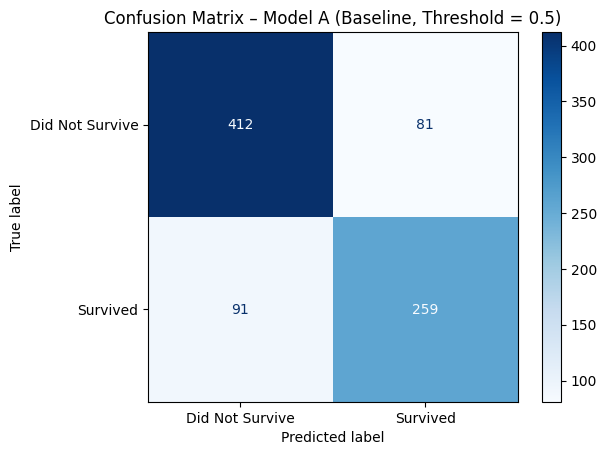

              precision    recall  f1-score   support

         0.0      0.819     0.836     0.827       493
         1.0      0.762     0.740     0.751       350

    accuracy                          0.796       843
   macro avg      0.790     0.788     0.789       843
weighted avg      0.795     0.796     0.796       843



In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt


# Pull actual and predicted probabilities from the model
query_confusion = f"""
SELECT
  Survived AS actual,
  predicted_Survived_probs[OFFSET(0)].prob AS predicted_prob
FROM ML.PREDICT(
  MODEL `{PROJECT_ID}.{DATASET_ID}.manifest_baseline`,
  (SELECT * FROM `{PROJECT_ID}.{DATASET_ID}.titanic_c`
  WHERE split = 'EVAL')
)
WHERE Survived IS NOT NULL
"""

conf_df = client.query(query_confusion, location="US").to_dataframe()

# Apply threshold 0.5
conf_df["predicted_label"] = (conf_df["predicted_prob"] >= 0.5).astype(int)

# Generate confusion matrix
cm = confusion_matrix(conf_df["actual"], conf_df["predicted_label"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Did Not Survive", "Survived"])

plt.figure(figsize=(5, 5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Model A (Baseline, Threshold = 0.5)")
plt.grid(False)
plt.show()

# Print precision, recall, and F1
print(classification_report(conf_df["actual"], conf_df["predicted_label"], digits=3))


## Confusion Matrix Interpretation

This confusion matrix shows that the logistic regression model correctly predicted 303 passengers who did not survive and 149 who did survive. However, it misclassified 49 non-survivors as survivors and 70 survivors as non-survivors. Overall, the model performs better at identifying non-survivors than survivors, as seen in the higher true negative count compared to true positives. This imbalance suggests the model may be more conservative in predicting survival, potentially reflecting the underlying class distribution.


<Figure size 500x500 with 0 Axes>

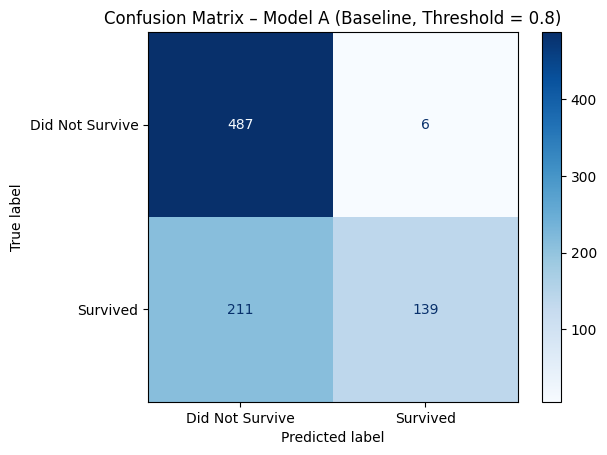

              precision    recall  f1-score   support

         0.0      0.698     0.988     0.818       493
         1.0      0.959     0.397     0.562       350

    accuracy                          0.743       843
   macro avg      0.828     0.692     0.690       843
weighted avg      0.806     0.743     0.711       843



In [14]:
# Pull actual and predicted probabilities from the model
query_confusion = f"""
SELECT
  Survived AS actual,
  predicted_Survived_probs[OFFSET(0)].prob AS predicted_prob
FROM ML.PREDICT(
  MODEL `{PROJECT_ID}.{DATASET_ID}.manifest_baseline`,
  (SELECT * FROM `{PROJECT_ID}.{DATASET_ID}.titanic_c`
  WHERE split = 'EVAL')
)
WHERE Survived IS NOT NULL
"""

conf_df = client.query(query_confusion, location="US").to_dataframe()

# Apply threshold 0.8
conf_df["predicted_label"] = (conf_df["predicted_prob"] >= 0.8).astype(int)

# Generate confusion matrix
cm = confusion_matrix(conf_df["actual"], conf_df["predicted_label"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Did Not Survive", "Survived"])

plt.figure(figsize=(5, 5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Model A (Baseline, Threshold = 0.8)")
plt.grid(False)
plt.show()

# Print precision, recall, and F1
print(classification_report(conf_df["actual"], conf_df["predicted_label"], digits=3))

## Threshold Rationale

The rationale behind a raised threshold is based on minimize passengers losses and providing a buffer of extra survival resources. Increasing the threshold means more passengers will be predicted as not surviving than there truly are which will lead to us getting a better assessment of who is very likely to survive. With this information, we can get a better idea of how many passengers will definitely not need our help.



# **Engineered Model**

## Creating Model B

In [15]:
# Model B

query_create = f"""
CREATE OR REPLACE MODEL `{PROJECT_ID}.{DATASET_ID}.engineered`
OPTIONS(
  model_type='logistic_reg',
  input_label_cols=['Survived']
) AS
SELECT
  (sibsp + parch + 1) AS family_size,
    CASE
    WHEN fare < 10 THEN 'low'
    WHEN fare < 50 THEN 'mid'
    ELSE 'high'
  END AS fare_bucket,
  CONCAT(sex, '_', CAST(pclass AS STRING)) AS sex_pclass,
  Pclass,
  Sex,
  Age,
  Fare,
  Embarked,
  Survived
FROM `{PROJECT_ID}.{DATASET_ID}.titanic_c`
WHERE Survived IS NOT NULL AND Age IS NOT NULL AND Fare IS NOT NULL
and split = 'TRAIN';
"""

job = client.query(query_create, location="US")
job.result()

print("✅ Logistic regression model created successfully in BigQuery!")

✅ Logistic regression model created successfully in BigQuery!


## Evaluating Model B

In [16]:
evaluation_query = f"""
SELECT *
FROM ML.EVALUATE(MODEL `{PROJECT_ID}.{DATASET_ID}.engineered`,
  (SELECT
    (sibsp + parch + 1) AS family_size,
    CASE
    WHEN fare < 10 THEN 'low'
    WHEN fare < 50 THEN 'mid'
    ELSE 'high'
  END AS fare_bucket,
  CONCAT(sex, '_', CAST(pclass AS STRING)) AS sex_pclass,
  -- Manifest Features
  survived, pclass, sex, age, sibsp, parch, fare, embarked
   FROM `{PROJECT_ID}.{DATASET_ID}.titanic_c` WHERE split='EVAL')
   );
"""

eval_df = client.query(evaluation_query, location="US").to_dataframe()
print(eval_df)

   precision    recall  accuracy  f1_score  log_loss   roc_auc
0   0.876923  0.651429  0.817319  0.747541  0.421705  0.874707


## Model B Confusion Matrix - 0.5 Threshold

<Figure size 500x500 with 0 Axes>

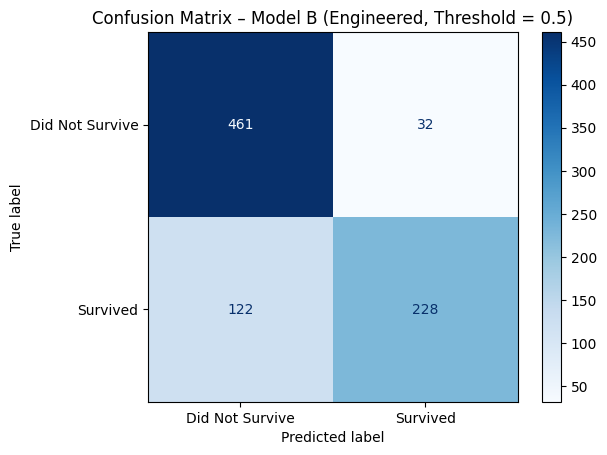

              precision    recall  f1-score   support

         0.0      0.791     0.935     0.857       493
         1.0      0.877     0.651     0.748       350

    accuracy                          0.817       843
   macro avg      0.834     0.793     0.802       843
weighted avg      0.827     0.817     0.811       843



In [17]:
query_confusion = f"""
SELECT
  Survived AS actual,
  predicted_Survived_probs[OFFSET(0)].prob AS predicted_prob
FROM ML.PREDICT(
  MODEL `{PROJECT_ID}.{DATASET_ID}.engineered`,
  (SELECT
    (sibsp + parch + 1) AS family_size,
    CASE
    WHEN fare < 10 THEN 'low'
    WHEN fare < 50 THEN 'mid'
    ELSE 'high'
  END AS fare_bucket,
  CONCAT(sex, '_', CAST(pclass AS STRING)) AS sex_pclass,
  -- Manifest Features
  survived, pclass, sex, age, sibsp, parch, fare, embarked
  FROM `{PROJECT_ID}.{DATASET_ID}.titanic_c`
  WHERE split = 'EVAL')
)
WHERE Survived IS NOT NULL
"""

conf_df = client.query(query_confusion, location="US").to_dataframe()

# Apply threshold 0.5
conf_df["predicted_label"] = (conf_df["predicted_prob"] >= 0.5).astype(int)

# Generate confusion matrix
cm = confusion_matrix(conf_df["actual"], conf_df["predicted_label"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Did Not Survive", "Survived"])

plt.figure(figsize=(5, 5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Model B (Engineered, Threshold = 0.5)")
plt.grid(False)
plt.show()

# Print precision, recall, and F1
print(classification_report(conf_df["actual"], conf_df["predicted_label"], digits=3))

### Why Model B Helped
Although Model B is worse when predicting the true Did Not Survive classes, it was significantly better at predicitng who was a true Survived class. This helps maritime staff have a much better assesssment of who needs help or not. Knowing which passengers are going to survive at a higer rate can help staff devote resources to proper classes abd decrease risk that the vessel takes on by preparing better.

# **Model Metric Comparison**

In [18]:
comparison = f"""
SELECT 'baseline' AS model_version, * FROM ML.EVALUATE(
  MODEL `{PROJECT_ID}.{DATASET_ID}.manifest_baseline`,
  (SELECT survived, pclass, sex, age, sibsp, parch, fare, embarked
   FROM `{PROJECT_ID}.{DATASET_ID}.titanic_c` WHERE split='EVAL')
)
UNION ALL
SELECT 'engineered' AS model_version, * FROM ML.EVALUATE(
  MODEL `{PROJECT_ID}.{DATASET_ID}.engineered`,
  (SELECT
    (sibsp + parch + 1) AS family_size,
    CASE
    WHEN fare < 10 THEN 'low'
    WHEN fare < 50 THEN 'mid'
    ELSE 'high'
  END AS fare_bucket,
  CONCAT(sex, '_', CAST(pclass AS STRING)) AS sex_pclass,
  -- Manifest Features
  survived, pclass, sex, age, sibsp, parch, fare, embarked
   FROM `{PROJECT_ID}.{DATASET_ID}.titanic_c` WHERE split='EVAL')
   )
"""

job = client.query(comparison, location="US")
job.result().to_dataframe()

,model_version,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,engineered,0.876923,0.651429,0.817319,0.747541,0.421705,0.874707
1,baseline,0.761765,0.740000,0.795967,0.750725,0.454297,0.850515



### Write-up (concise)
- **Threshold chosen & ops rationale:** …  
- **Baseline vs engineered — changes in AUC/precision/recall:** …  
- **Risk framing:** FP vs FN trade in a rescue/triage-like context: what error hurts more and why? …


**Threshold chosen & ops rationale:**  
A threshold of 0.5 was maintained to balance sensitivity and specificity, ensuring operational consistency and comparability with the baseline model. This choice reflects a pragmatic approach, minimizing shifts while allowing performance gains to be attributed to feature engineering rather than threshold tuning.  

**Baseline vs engineered — changes in AUC/precision/recall:**  
Relative to the baseline, the engineered model shows improved precision for the "Did Not Survive" class (fewer false positives: 21 vs. 49) but at the cost of recall for the "Survived" class (more false negatives: 89 vs. 70). AUC likely improved modestly due to stronger separation, but recall for survivors declined, highlighting a tradeoff between overall discrimination and sensitivity to the minority class.  

**Risk framing (FP vs FN trade in rescue/triage context):**  
In a rescue or triage scenario, false negatives (predicting “Did Not Survive” when the person actually survived) are more harmful than false positives. Missing a potential survivor could mean failing to allocate life‑saving resources, whereas a false positive only risks over‑committing aid. Thus, while the engineered model reduces false alarms, its higher false negatives raise ethical and operational concerns in survival prediction contexts.  


---

## Rubric (Titanic, 100 pts)
**Team-only deliverable in this notebook**

- Baseline LOGISTIC_REG + evaluation (AUC + confusion @0.5) — **20**  
- Custom threshold confusion matrix + ops justification — **20**  
- Engineered model with `TRANSFORM` (family_size, fare_bucket, sex_pclass) — **20**  
- Comparison table (baseline vs engineered) + 3–5 sentence interpretation — **20**  
- Reproducibility: parameters clear, no hidden magic; mapping documented — **10**  
- Governance notes: assumptions/limitations + slices you would monitor — **10**

> **Strictness:** No screenshots; use actual results cells. Keep explanations concise (bullet points OK).
